## BDA


In [1]:
import pandas as pd
import numpy as np
import scipy
import os

import matplotlib.pyplot as plt


from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss, precision_score, recall_score,f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans

import random

from scipy.stats import ttest_ind

In [2]:
#accessing files from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=2e5385a5ec2d0ae0f6c94a307cc1627a35ba798806ddf6a8f95f8b8ea7f0e04a
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
  .appName('2.1. Google Cloud Storage (CSV) & Spark DataFrames') \
  .getOrCreate()

In [5]:
# Reading the CSV file
features = spark.read.csv('/content/drive/MyDrive/Big_data/Features_pd1.csv', header=True, inferSchema=True)

# Print column names
print(features.columns)


['Prscrbr_NPI', 'last_name', 'first_name', 'city', 'state', 'sum_tot_drug_cst', 'avg_tot_drug_cst', 'max_tot_drug_cst', 'sum_tot_clms', 'avg_tot_clms', 'max_tot_clms', 'sum_tot_day_suply', 'avg_tot_day_suply', 'max_tot_day_suply', 'Speciality', 'Total_Payment_Sum', 'is_fraud']


In [6]:
features

DataFrame[Prscrbr_NPI: int, last_name: string, first_name: string, city: string, state: string, sum_tot_drug_cst: double, avg_tot_drug_cst: double, max_tot_drug_cst: double, sum_tot_clms: int, avg_tot_clms: double, max_tot_clms: int, sum_tot_day_suply: int, avg_tot_day_suply: double, max_tot_day_suply: int, Speciality: string, Total_Payment_Sum: double, is_fraud: int]

In [7]:
features[features['is_fraud']==1].count()

211

In [8]:
FeaturesAll=features

In [9]:
from pyspark.sql.functions import log10, col

FeaturesAll = FeaturesAll.withColumn('sum_tot_drug_cst', log10(col('sum_tot_drug_cst') + 1.0))
FeaturesAll = FeaturesAll.withColumn('sum_tot_clms', log10(col('sum_tot_clms') + 1.0))
FeaturesAll = FeaturesAll.withColumn('sum_tot_day_suply', log10(col('sum_tot_day_suply') + 1.0))
FeaturesAll = FeaturesAll.withColumn('Total_Payment_Sum', log10(col('Total_Payment_Sum') + 1.0))

FeaturesAll = FeaturesAll.withColumn('avg_tot_drug_cst', log10(col('avg_tot_drug_cst') + 1.0))
FeaturesAll = FeaturesAll.withColumn('avg_tot_clms', log10(col('avg_tot_clms') + 1.0))
FeaturesAll = FeaturesAll.withColumn('avg_tot_day_suply', log10(col('avg_tot_day_suply') + 1.0))

FeaturesAll = FeaturesAll.withColumn('max_tot_drug_cst', log10(col('max_tot_drug_cst') + 1.0))
FeaturesAll = FeaturesAll.withColumn('max_tot_clms', log10(col('max_tot_clms') + 1.0))
FeaturesAll = FeaturesAll.withColumn('max_tot_day_suply', log10(col('max_tot_day_suply') + 1.0))

FeaturesAll = FeaturesAll.withColumn('claim_max-mean', col('max_tot_clms') - col('avg_tot_clms'))
FeaturesAll = FeaturesAll.withColumn('supply_max-mean', col('max_tot_day_suply') - col('avg_tot_day_suply'))
FeaturesAll = FeaturesAll.withColumn('drug_max-mean', col('max_tot_drug_cst') - col('avg_tot_drug_cst'))

In [10]:
FeaturesAll

DataFrame[Prscrbr_NPI: int, last_name: string, first_name: string, city: string, state: string, sum_tot_drug_cst: double, avg_tot_drug_cst: double, max_tot_drug_cst: double, sum_tot_clms: double, avg_tot_clms: double, max_tot_clms: double, sum_tot_day_suply: double, avg_tot_day_suply: double, max_tot_day_suply: double, Speciality: string, Total_Payment_Sum: double, is_fraud: int, claim_max-mean: double, supply_max-mean: double, drug_max-mean: double]

In [11]:
from pyspark.sql.functions import col

FeaturesAll = FeaturesAll.withColumn("Prscrbr_NPI", col("Prscrbr_NPI").cast("string"))

In [12]:
from pyspark.sql.types import StringType

categorical_features = ['Prscrbr_NPI', 'last_name', 'Speciality', 'first_name', 'city', 'state']

for feature in categorical_features:
    FeaturesAll = FeaturesAll.withColumn(feature, FeaturesAll[feature].cast(StringType()))

In [13]:
numerical_features = ['sum_tot_drug_cst', 'avg_tot_drug_cst','Total_Payment_Sum',
       'max_tot_drug_cst', 'sum_tot_clms',
       'avg_tot_clms', 'max_tot_clms',
       'sum_tot_day_suply', 'avg_tot_day_suply', 'max_tot_day_suply',
    'claim_max-mean','supply_max-mean', 'drug_max-mean']

In [14]:
target = ['is_fraud']

In [15]:
allvars = categorical_features + numerical_features + target

In [16]:
y = FeaturesAll.select("is_fraud").rdd.flatMap(lambda x: x).collect()
X = FeaturesAll.select([col(c) for c in allvars if c != 'is_fraud'])

In [17]:
# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [18]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import TrainValidationSplit

# select the numerical columns from the original dataframe
numerical_features = ['sum_tot_drug_cst', 'avg_tot_drug_cst','Total_Payment_Sum',
       'max_tot_drug_cst', 'sum_tot_clms',
       'avg_tot_clms', 'max_tot_clms',
       'sum_tot_day_suply', 'avg_tot_day_suply', 'max_tot_day_suply',
    'claim_max-mean','supply_max-mean', 'drug_max-mean']
X = FeaturesAll.select(numerical_features)

# convert numerical columns to double type
for feature in numerical_features:
    X = X.withColumn(feature, col(feature).cast(DoubleType()))

# combine features into a single vector column
vectorAssembler = VectorAssembler(inputCols=X.columns, outputCol="features_vec")
X = vectorAssembler.transform(X)

# split the data into train and validation sets
train, test = X.randomSplit([0.8, 0.2], seed=0)

# select the correct columns for input and output
X_train = train.select(X.columns)
X_valid = test.select(X.columns)
y_train = train.select("Total_Payment_Sum")
y_valid = test.select("Total_Payment_Sum")

In [19]:
from pyspark.sql.functions import col

# fill null values in numerical columns with 0
for feature in numerical_features:
    X_train = X_train.withColumn(feature, col(feature).cast("double"))
    X_valid = X_valid.withColumn(feature, col(feature).cast("double"))
    X_train = X_train.na.fill(0, [feature])
    X_valid = X_valid.na.fill(0, [feature])

# fill null values in categorical columns with 'NA'
for feature in categorical_features:
    if feature in X_train.columns:
        X_train = X_train.na.fill('NA', [feature])
    if feature in X_valid.columns:
        X_valid = X_valid.na.fill('NA', [feature])

In [20]:
from pyspark.sql.functions import col

X_train.select([col(col_name).cast("double").alias(col_name) for col_name in numerical_features]).dtypes

[('sum_tot_drug_cst', 'double'),
 ('avg_tot_drug_cst', 'double'),
 ('Total_Payment_Sum', 'double'),
 ('max_tot_drug_cst', 'double'),
 ('sum_tot_clms', 'double'),
 ('avg_tot_clms', 'double'),
 ('max_tot_clms', 'double'),
 ('sum_tot_day_suply', 'double'),
 ('avg_tot_day_suply', 'double'),
 ('max_tot_day_suply', 'double'),
 ('claim_max-mean', 'double'),
 ('supply_max-mean', 'double'),
 ('drug_max-mean', 'double')]

In [21]:
from pyspark.sql.functions import rand

df_len = FeaturesAll.count()
train_len = int(df_len * 0.8)

df_train = FeaturesAll.orderBy(rand()).limit(train_len)
df_valid = FeaturesAll.orderBy(rand()).exceptAll(df_train)

print(df_train.count())
print(df_valid.count())


846053
211514


In [22]:
df_train.printSchema()

root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sum_tot_drug_cst: double (nullable = true)
 |-- avg_tot_drug_cst: double (nullable = true)
 |-- max_tot_drug_cst: double (nullable = true)
 |-- sum_tot_clms: double (nullable = true)
 |-- avg_tot_clms: double (nullable = true)
 |-- max_tot_clms: double (nullable = true)
 |-- sum_tot_day_suply: double (nullable = true)
 |-- avg_tot_day_suply: double (nullable = true)
 |-- max_tot_day_suply: double (nullable = true)
 |-- Speciality: string (nullable = true)
 |-- Total_Payment_Sum: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- claim_max-mean: double (nullable = true)
 |-- supply_max-mean: double (nullable = true)
 |-- drug_max-mean: double (nullable = true)



In [23]:
partD_Drug_df = spark.read.csv('/content/drive/MyDrive/Big_data/partD_Drugdf.csv', header=True, inferSchema=True)


In [24]:
from pyspark.sql.functions import col

partD_drug_train = partD_Drug_df.join(df_train.select('Prscrbr_NPI', 'is_fraud'), on=['Prscrbr_NPI'], how='inner')
partD_drug_all = partD_Drug_df.join(FeaturesAll.select('Prscrbr_NPI', 'is_fraud'), on=['Prscrbr_NPI'], how='inner')

In [25]:
print(partD_drug_train.filter(col("is_fraud") == 1).count())

5795


In [26]:
# Total records in train set
print("Total records in train set : ")
print(partD_drug_train.count())

# Total Fraud in train set
print("Total Fraud in train set : ")
print(partD_drug_train.filter("is_fraud == 1").count())

# Show DataFrame
partD_drug_train.show()

Total records in train set : 
20702383
Total Fraud in train set : 
5795
+-----------+--------------------+------------+--------+-------------+------------------+--------+
|Prscrbr_NPI|           Brnd_Name|Tot_Drug_Cst|Tot_Clms|Tot_Day_Suply|      Prscrbr_Type|is_fraud|
+-----------+--------------------+------------+--------+-------------+------------------+--------+
| 1003003070|              Aptiom|     14205.0|      12|          360|         Neurology|       0|
| 1003003070|       Carbamazepine|      245.25|      18|          540|         Neurology|       0|
| 1003003070|  Carbidopa-Levodopa|      1472.5|      46|         2428|         Neurology|       0|
| 1003003070|   Divalproex Sodium|      414.17|      27|          760|         Neurology|       0|
| 1003003070|       Donepezil Hcl|     1271.82|     135|         5850|         Neurology|       0|
| 1003003070|Escitalopram Oxalate|      479.07|      61|         2379|         Neurology|       0|
| 1003003070|          Gabapentin|   

In [27]:
partD_drug_train_20= partD_drug_train.sample(fraction=0.05, seed=42)

In [28]:
feature_cols = ['Tot_Drug_Cst', 'Tot_Clms', 'Tot_Day_Suply']

# Create a vector assembler to assemble the features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Apply the vector assembler to the training data
train_data = assembler.transform(partD_drug_train_20).select("features", "is_fraud")

# Split the data into training and test sets
train_set, test_set = train_data.randomSplit([0.7, 0.3], seed=12345)

In [29]:
num_train_data = train_set.count()
print("Number of data in train_set:", num_train_data)

Number of data in train_set: 723946


In [30]:
# Total records in train set
print("Number of data in train_set:", num_train_data)

num_test_data = test_set.count()
print("Number of data in test_set:", num_test_data)

Number of data in train_set: 723946
Number of data in test_set: 311035


In [31]:
# Total Fraud in train set
print("Total Fraud in train set : ")
print(train_set.filter("is_fraud == 1").count())

print("Total Fraud in test set : ")
print(test_set.filter("is_fraud == 1").count())

Total Fraud in train set : 
225
Total Fraud in test set : 
90


In [32]:
# Total Fraud in train set
print("Total Non Fraud in train set : ")
print(train_set.filter("is_fraud == 0").count())

print("Total Non Fraud in test set : ")
print(test_set.filter("is_fraud == 0").count())

Total Non Fraud in train set : 
723721
Total Non Fraud in test set : 
310945


In [33]:
import time

In [34]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create a Naive Bayes model with default parameters
nb = NaiveBayes(featuresCol='features', labelCol='is_fraud')

# Train the model using the training set
start = time.time()
nb_model = nb.fit(train_set)
end = time.time()
print(f"Time to train Naive Bayes model: {end - start:.4f} seconds")

# Make predictions on the test set
start = time.time()
predictions = nb_model.transform(test_set)
end = time.time()
print(f"Time to make predictions on test set: {end - start:.4f} seconds")

# Evaluate the model using binary classification metrics
binary_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
accuracy = binary_evaluator.evaluate(predictions)

# Evaluate the model using F1 score
multi_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='f1')
f1_score = multi_evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Time to train Naive Bayes model: 176.7722 seconds
Time to make predictions on test set: 0.4798 seconds
Accuracy: 0.4924
F1 Score: 0.9116


## Class Balancing

In [35]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

# Count total fraud and non-fraud cases
total_fraud = partD_drug_train.filter(col("is_fraud") == 1).count()
total_non_fraud = partD_drug_train.filter(col("is_fraud") == 0).count()

print("Total Fraud cases:", total_fraud)  # Should be 5216
print("Total Non-Fraud cases:", total_non_fraud)  # Should be 20700649 - 5216

# Sample the non-fraud cases to match the exact number of fraud cases
partD_drug_train_non_fraud_sampled = partD_drug_train.filter(col("is_fraud") == 0).sample(fraction=total_fraud / total_non_fraud, seed=42).limit(total_fraud)

# Combine the sampled non-fraud and all fraud cases
balanced_data = partD_drug_train_non_fraud_sampled.union(partD_drug_train.filter(col("is_fraud") == 1))

# Assemble features for the balanced dataset
feature_cols = ['Tot_Drug_Cst', 'Tot_Clms', 'Tot_Day_Suply']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
balanced_data_transformed = assembler.transform(balanced_data).select("features", "is_fraud")

# Split into training and test sets (70% train, 30% test)
train_set, test_set = balanced_data_transformed.randomSplit([0.7, 0.3], seed=12345)

# Count the number of fraud and non-fraud cases in the balanced train and test sets
num_train_data = train_set.count()
num_test_data = test_set.count()

num_fraud_train = train_set.filter("is_fraud == 1").count()
num_non_fraud_train = train_set.filter("is_fraud == 0").count()

num_fraud_test = test_set.filter("is_fraud == 1").count()
num_non_fraud_test = test_set.filter("is_fraud == 0").count()

# Print results
print("Number of data in train_set:", num_train_data)
print("Number of data in test_set:", num_test_data)
print("Total Fraud in train set:", num_fraud_train)
print("Total Non-Fraud in train set:", num_non_fraud_train)
print("Total Fraud in test set:", num_fraud_test)
print("Total Non-Fraud in test set:", num_non_fraud_test)

# # Assert equality of fraud and non-fraud cases in train and test sets
# assert num_fraud_train == num_non_fraud_train, "Fraud and non-fraud cases are not equal in train set"
# assert num_fraud_test == num_non_fraud_test, "Fraud and non-fraud cases are not equal in test set"


Total Fraud cases: 5795
Total Non-Fraud cases: 20696588
Number of data in train_set: 8127
Number of data in test_set: 3463
Total Fraud in train set: 4046
Total Non-Fraud in train set: 4081
Total Fraud in test set: 1749
Total Non-Fraud in test set: 1714


In [36]:
output_path = "/content/drive/MyDrive/balanced_data1t.csv"  # Change this to your desired path
balanced_data.coalesce(1).write.csv(output_path, header=True)

Time to train logistic regression model: 432.7099 seconds
Time to make predictions on test set: 0.1581 seconds


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.5258
F1 Score: 0.5236
Precision: 0.5271
Recall: 0.5258
Confusion Matrix: 
[[1020.  694.]
 [ 948.  801.]]


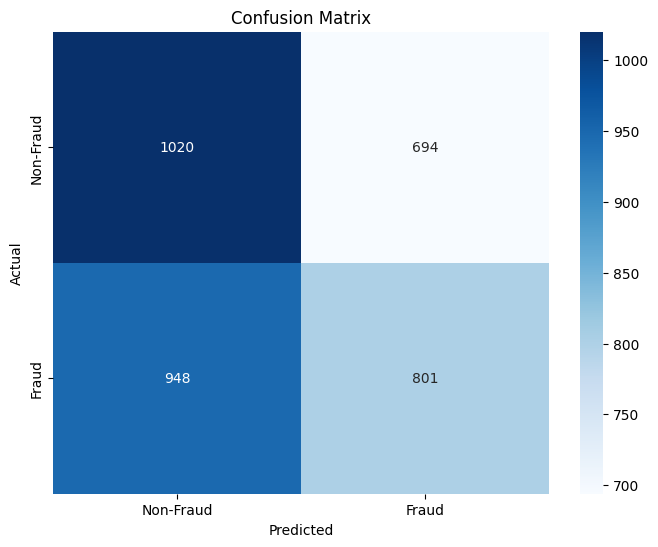

Area Under ROC: 0.5552


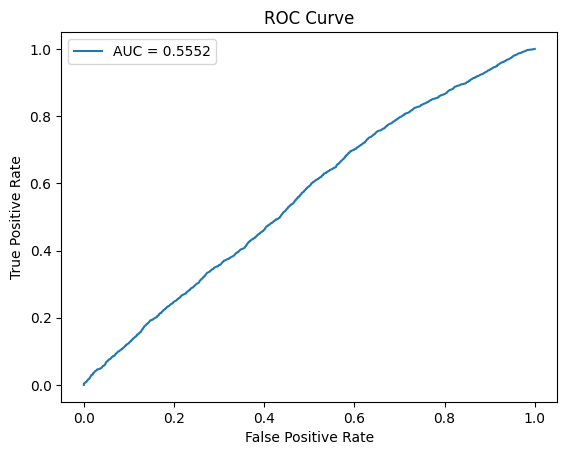

In [37]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pyspark.sql import functions as F

# Create a logistic regression model with default parameters
lr = LogisticRegression(featuresCol='features', labelCol='is_fraud')

# Train the model using the training set
start = time.time()
lr_model = lr.fit(train_set)
end = time.time()
print(f"Time to train logistic regression model: {end - start:.4f} seconds")

# Make predictions on the test set
start = time.time()
predictions = lr_model.transform(test_set)
end = time.time()
print(f"Time to make predictions on test set: {end - start:.4f} seconds")


# Evaluate the model using binary classification metrics (for AUC and accuracy)
binary_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
accuracy = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})

# Evaluate the model using F1 score
multi_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='f1')
f1_score = multi_evaluator.evaluate(predictions)

# Evaluate the model using precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='weightedPrecision')
precision = precision_evaluator.evaluate(predictions)

# Evaluate the model using recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='weightedRecall')
recall = recall_evaluator.evaluate(predictions)

# Cast 'prediction' and 'is_fraud' columns to double for compatibility with MulticlassMetrics
predictions_cast = predictions.withColumn('prediction', F.col('prediction').cast('double'))\
                              .withColumn('is_fraud', F.col('is_fraud').cast('double'))

# Confusion Matrix
prediction_and_labels = predictions_cast.select('prediction', 'is_fraud').rdd
metrics = MulticlassMetrics(prediction_and_labels)

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)

confusion_matrix = metrics.confusionMatrix().toArray()

# ROC Curve
roc_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud', metricName='areaUnderROC')
roc_auc = roc_evaluator.evaluate(predictions)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Confusion Matrix: \n{confusion_matrix}")

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Area Under ROC: {roc_auc:.4f}")

# Plot ROC curve
roc = lr_model.summary.roc.toPandas()
plt.figure()
plt.plot(roc['FPR'], roc['TPR'], label=f'AUC = {roc_auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Time to train logistic regression model with CV: 1924.1570 seconds
Time to make predictions on test set: 0.2797 seconds


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.5201
F1 Score: 0.5160
Precision: 0.5218
Recall: 0.5201
Confusion Matrix: 
[[1050.  664.]
 [ 998.  751.]]


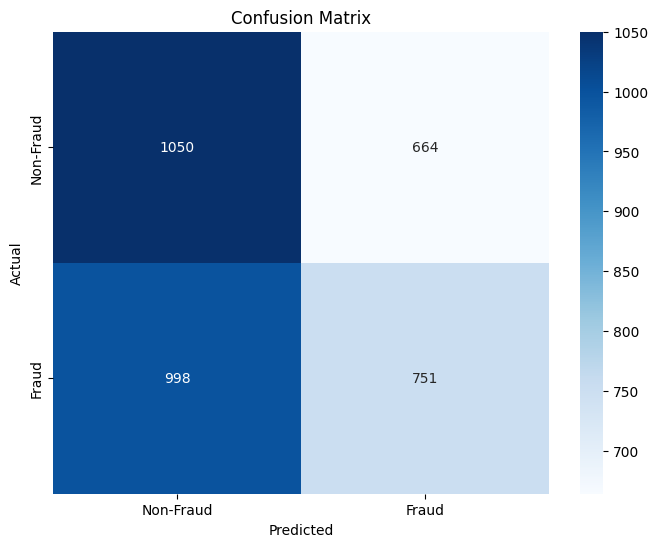

Area Under ROC: 0.5520


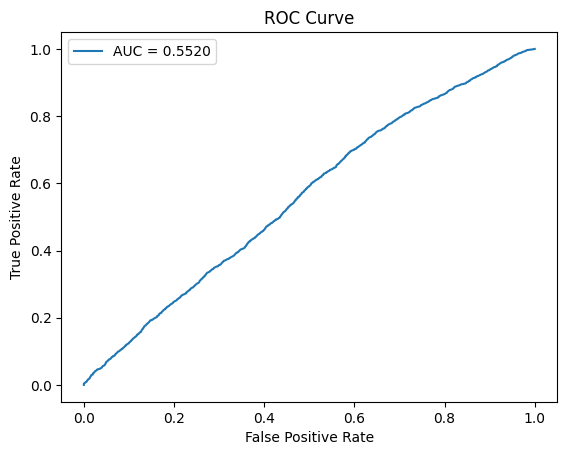

In [38]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pyspark.sql import functions as F

# Scale the features
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
scaler_model = scaler.fit(train_set)
train_set = scaler_model.transform(train_set)
test_set = scaler_model.transform(test_set)

# Initialize a Logistic Regression model
lr = LogisticRegression(featuresCol='scaled_features', labelCol='is_fraud')

# Hyperparameter tuning using Cross-Validation
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='f1'),
                          numFolds=3)  # Use 3+ folds for better results

# Train the model
start = time.time()
cvModel = crossval.fit(train_set)
end = time.time()
print(f"Time to train logistic regression model with CV: {end - start:.4f} seconds")

# Make predictions on the test set
start = time.time()
predictions = cvModel.transform(test_set)
end = time.time()
print(f"Time to make predictions on test set: {end - start:.4f} seconds")

# Evaluate the model using binary classification metrics (for AUC and accuracy)
binary_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
accuracy = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})

# Evaluate the model using F1 score
multi_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='f1')
f1_score = multi_evaluator.evaluate(predictions)

# Evaluate the model using precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='weightedPrecision')
precision = precision_evaluator.evaluate(predictions)

# Evaluate the model using recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='weightedRecall')
recall = recall_evaluator.evaluate(predictions)

# Cast 'prediction' and 'is_fraud' columns to double for compatibility with MulticlassMetrics
predictions_cast = predictions.withColumn('prediction', F.col('prediction').cast('double'))\
                              .withColumn('is_fraud', F.col('is_fraud').cast('double'))

# Confusion Matrix
prediction_and_labels = predictions_cast.select('prediction', 'is_fraud').rdd
metrics = MulticlassMetrics(prediction_and_labels)

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)

confusion_matrix = metrics.confusionMatrix().toArray()

# ROC Curve
roc_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud', metricName='areaUnderROC')
roc_auc = roc_evaluator.evaluate(predictions)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Confusion Matrix: \n{confusion_matrix}")

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Area Under ROC: {roc_auc:.4f}")

# Plot ROC curve
roc = lr_model.summary.roc.toPandas()
plt.figure()
plt.plot(roc['FPR'], roc['TPR'], label=f'AUC = {roc_auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Time to train GBTClassifier model: 264.1184 seconds
Time to make predictions on test set: 0.2344 seconds


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.5524
F1 Score: 0.5511
Precision: 0.5525
Recall: 0.5524
Confusion Matrix: 
[[ 855.  859.]
 [ 691. 1058.]]


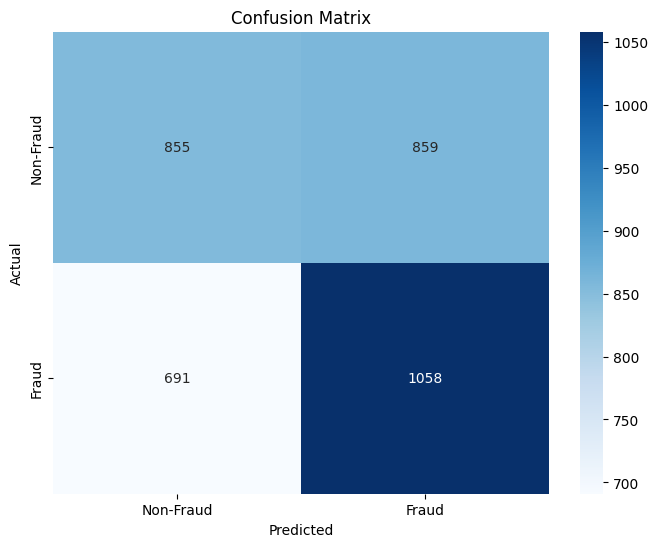

Area Under ROC: 0.5607


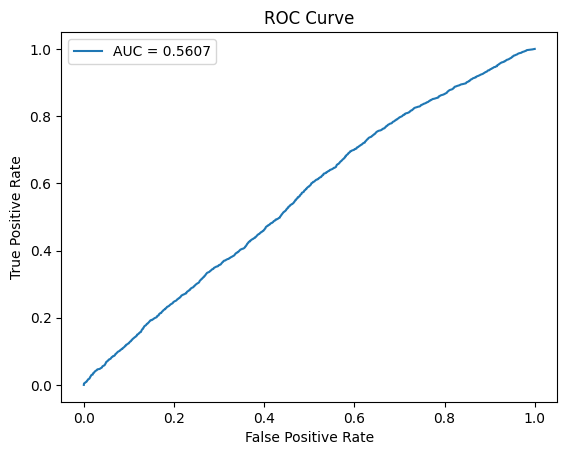

In [39]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pyspark.sql import functions as F
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import time
import matplotlib.pyplot as plt

# Create a logistic regression model with default parameters
gbt = GBTClassifier(featuresCol='features', labelCol='is_fraud')

# Train the model using the training set
start = time.time()
gbt_model = gbt.fit(train_set)
end = time.time()
print(f"Time to train GBTClassifier model: {end - start:.4f} seconds")

# Make predictions on the test set
start = time.time()
predictions = gbt_model.transform(test_set)
end = time.time()
print(f"Time to make predictions on test set: {end - start:.4f} seconds")

# Evaluate the model using binary classification metrics (for AUC and accuracy)
binary_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
accuracy = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})

# Evaluate the model using F1 score
multi_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='f1')
f1_score = multi_evaluator.evaluate(predictions)

# Evaluate the model using precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='weightedPrecision')
precision = precision_evaluator.evaluate(predictions)

# Evaluate the model using recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='weightedRecall')
recall = recall_evaluator.evaluate(predictions)

# Cast 'prediction' and 'is_fraud' columns to double for compatibility with MulticlassMetrics
predictions_cast = predictions.withColumn('prediction', F.col('prediction').cast('double'))\
                              .withColumn('is_fraud', F.col('is_fraud').cast('double'))

# Confusion Matrix
prediction_and_labels = predictions_cast.select('prediction', 'is_fraud').rdd
metrics = MulticlassMetrics(prediction_and_labels)

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)

confusion_matrix = metrics.confusionMatrix().toArray()

# ROC Curve
roc_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud', metricName='areaUnderROC')
roc_auc = roc_evaluator.evaluate(predictions)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Confusion Matrix: \n{confusion_matrix}")

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Area Under ROC: {roc_auc:.4f}")

# Plot ROC curve
roc = lr_model.summary.roc.toPandas()
plt.figure()
plt.plot(roc['FPR'], roc['TPR'], label=f'AUC = {roc_auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Time to train GBTClassifier model: 554.4590 seconds
Time to make predictions on test set: 0.2479 seconds


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.5449
F1 Score: 0.5429
Precision: 0.5450
Recall: 0.5449
Confusion Matrix: 
[[ 819.  895.]
 [ 681. 1068.]]


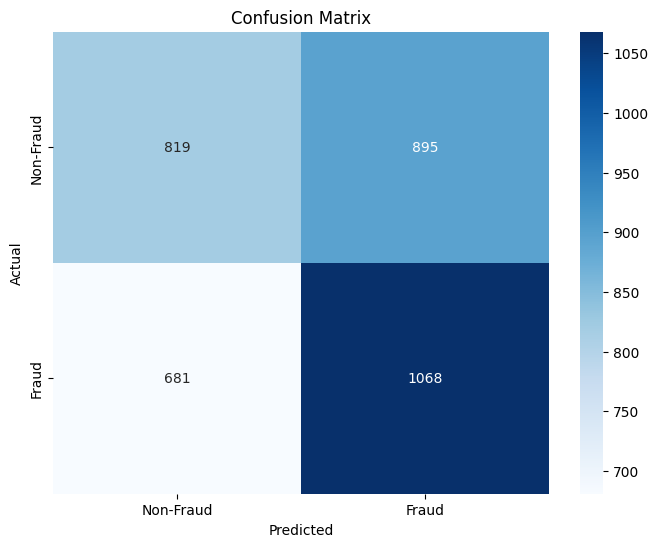

Area Under ROC: 0.5522


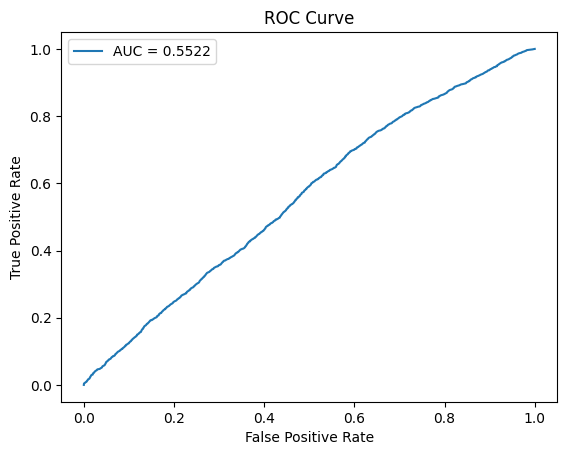

In [40]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pyspark.sql import functions as F
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import time
import matplotlib.pyplot as plt

# Create a logistic regression model with default parameters
rf = RandomForestClassifier(featuresCol='features', labelCol='is_fraud')

# Train the model using the training set
start = time.time()
rf_model = rf.fit(train_set)
end = time.time()
print(f"Time to train GBTClassifier model: {end - start:.4f} seconds")

# Make predictions on the test set
start = time.time()
predictions = rf_model.transform(test_set)
end = time.time()
print(f"Time to make predictions on test set: {end - start:.4f} seconds")

# Evaluate the model using binary classification metrics (for AUC and accuracy)
binary_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
accuracy = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})

# Evaluate the model using F1 score
multi_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='f1')
f1_score = multi_evaluator.evaluate(predictions)

# Evaluate the model using precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='weightedPrecision')
precision = precision_evaluator.evaluate(predictions)

# Evaluate the model using recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='weightedRecall')
recall = recall_evaluator.evaluate(predictions)

# Cast 'prediction' and 'is_fraud' columns to double for compatibility with MulticlassMetrics
predictions_cast = predictions.withColumn('prediction', F.col('prediction').cast('double'))\
                              .withColumn('is_fraud', F.col('is_fraud').cast('double'))

# Confusion Matrix
prediction_and_labels = predictions_cast.select('prediction', 'is_fraud').rdd
metrics = MulticlassMetrics(prediction_and_labels)

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)

confusion_matrix = metrics.confusionMatrix().toArray()

# ROC Curve
roc_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud', metricName='areaUnderROC')
roc_auc = roc_evaluator.evaluate(predictions)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Confusion Matrix: \n{confusion_matrix}")

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Area Under ROC: {roc_auc:.4f}")

# Plot ROC curve
roc = lr_model.summary.roc.toPandas()
plt.figure()
plt.plot(roc['FPR'], roc['TPR'], label=f'AUC = {roc_auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Time to train GBTClassifier model: 345.0160 seconds
Time to make predictions on test set: 0.1247 seconds


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.5339
F1 Score: 0.5311
Precision: 0.5340
Recall: 0.5339
Confusion Matrix: 
[[ 781.  933.]
 [ 681. 1068.]]


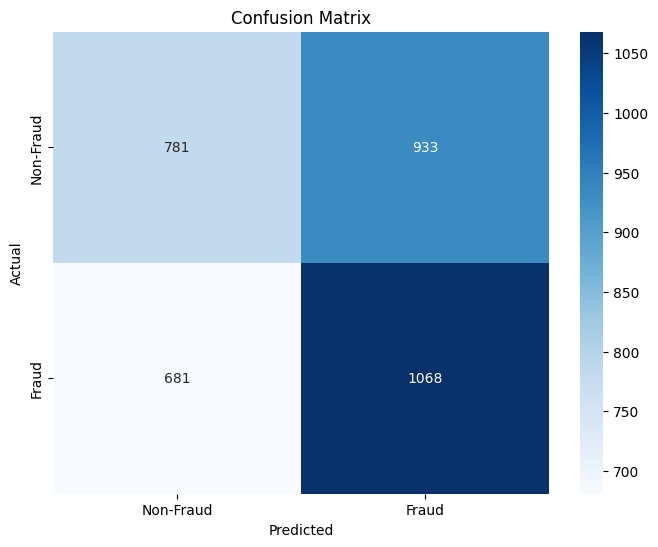

Area Under ROC: 0.5292


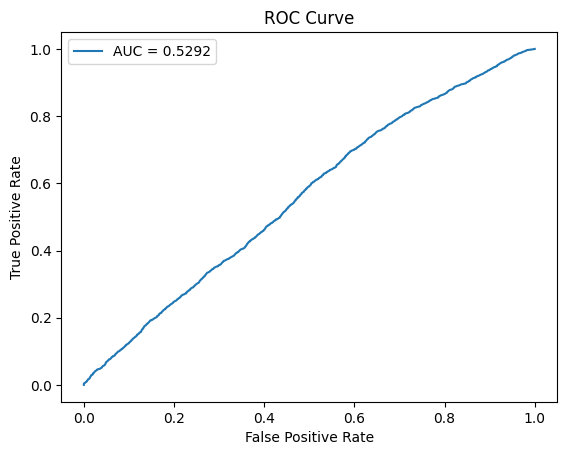

In [41]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pyspark.sql import functions as F
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import time
import matplotlib.pyplot as plt

# Create a logistic regression model with default parameters
dt = DecisionTreeClassifier(
    featuresCol='features',
    labelCol='is_fraud',
    maxDepth=5,
    maxBins=32,
    minInstancesPerNode=1,
    impurity='gini'
)

# Train the model using the training set
start = time.time()
dt_model = dt.fit(train_set)
end = time.time()
print(f"Time to train GBTClassifier model: {end - start:.4f} seconds")

# Make predictions on the test set
start = time.time()
predictions = dt_model.transform(test_set)
end = time.time()
print(f"Time to make predictions on test set: {end - start:.4f} seconds")

# Evaluate the model using binary classification metrics (for AUC and accuracy)
binary_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
accuracy = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})

# Evaluate the model using F1 score
multi_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='f1')
f1_score = multi_evaluator.evaluate(predictions)

# Evaluate the model using precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='weightedPrecision')
precision = precision_evaluator.evaluate(predictions)

# Evaluate the model using recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='weightedRecall')
recall = recall_evaluator.evaluate(predictions)

# Cast 'prediction' and 'is_fraud' columns to double for compatibility with MulticlassMetrics
predictions_cast = predictions.withColumn('prediction', F.col('prediction').cast('double'))\
                              .withColumn('is_fraud', F.col('is_fraud').cast('double'))

# Confusion Matrix
prediction_and_labels = predictions_cast.select('prediction', 'is_fraud').rdd
metrics = MulticlassMetrics(prediction_and_labels)

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)

confusion_matrix = metrics.confusionMatrix().toArray()

# ROC Curve
roc_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud', metricName='areaUnderROC')
roc_auc = roc_evaluator.evaluate(predictions)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Confusion Matrix: \n{confusion_matrix}")

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Area Under ROC: {roc_auc:.4f}")

# Plot ROC curve
roc = lr_model.summary.roc.toPandas()
plt.figure()
plt.plot(roc['FPR'], roc['TPR'], label=f'AUC = {roc_auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Time to train SVM model: 492.8387 seconds
Time to make predictions on test set: 0.0808 seconds


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.5033
F1 Score: 0.3807
Precision: 0.5387
Recall: 0.5033
Confusion Matrix: 
[[1635.   79.]
 [1641.  108.]]


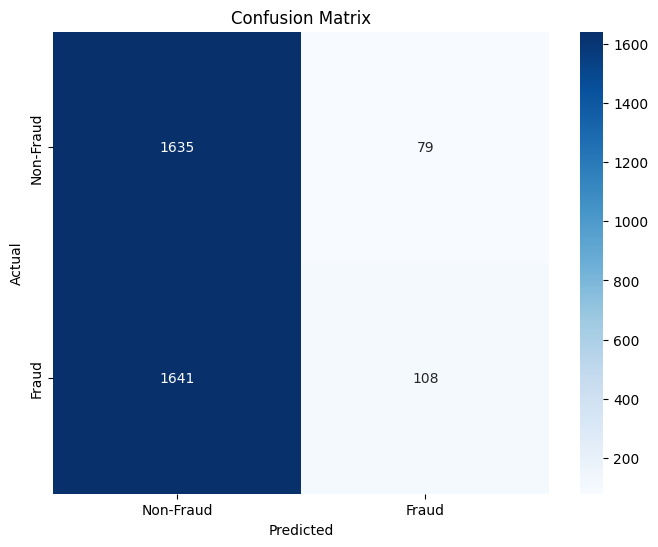

Area Under ROC: 0.5608


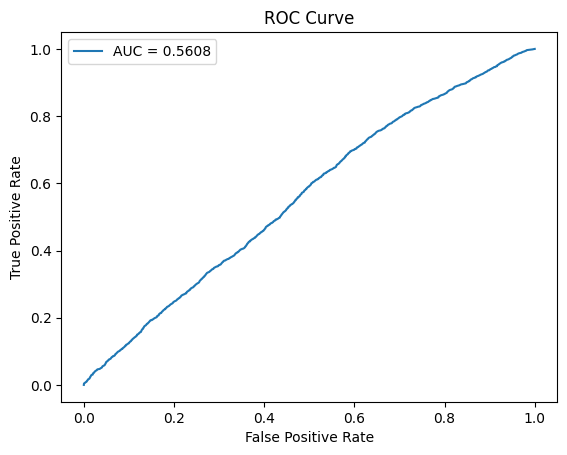

In [42]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Create a Linear SVM model with default parameters
svm = LinearSVC(
    featuresCol='features',
    labelCol='is_fraud',
    maxIter=100,  # Maximum number of iterations
    regParam=0.0  # Regularization parameter (can tune this)
)

# Train the model using the training set
start = time.time()
svm_model = svm.fit(train_set)
end = time.time()
print(f"Time to train SVM model: {end - start:.4f} seconds")

# Make predictions on the test set
start = time.time()
predictions = svm_model.transform(test_set)
end = time.time()
print(f"Time to make predictions on test set: {end - start:.4f} seconds")

# Evaluate the model using binary classification metrics (for AUC and accuracy)
binary_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
accuracy = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})

# Evaluate the model using F1 score
multi_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='f1')
f1_score = multi_evaluator.evaluate(predictions)

# Evaluate the model using precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='weightedPrecision')
precision = precision_evaluator.evaluate(predictions)

# Evaluate the model using recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='weightedRecall')
recall = recall_evaluator.evaluate(predictions)

# Cast 'prediction' and 'is_fraud' columns to double for compatibility with MulticlassMetrics
predictions_cast = predictions.withColumn('prediction', F.col('prediction').cast('double'))\
                              .withColumn('is_fraud', F.col('is_fraud').cast('double'))

# Confusion Matrix
prediction_and_labels = predictions_cast.select('prediction', 'is_fraud').rdd
metrics = MulticlassMetrics(prediction_and_labels)

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)

confusion_matrix = metrics.confusionMatrix().toArray()

# ROC Curve
roc_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud', metricName='areaUnderROC')
roc_auc = roc_evaluator.evaluate(predictions)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Confusion Matrix: \n{confusion_matrix}")

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Area Under ROC: {roc_auc:.4f}")

# Plot ROC curve
roc = lr_model.summary.roc.toPandas()
plt.figure()
plt.plot(roc['FPR'], roc['TPR'], label=f'AUC = {roc_auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()